In [94]:
import pandas as pd
import numpy as np
pd.set_option('display.max_columns', None)
from sklearn.model_selection import train_test_split, cross_val_score,cross_validate, GridSearchCV, KFold
from sklearn.ensemble import RandomForestClassifier,RandomForestRegressor
from sklearn.metrics import classification_report, accuracy_score, mean_squared_error
import seaborn as sns
import matplotlib.pyplot as plt
from sportsreference.ncaab.teams import Teams
from sportsreference.ncaab.teams import Team
from sportsreference.ncaab.roster import Player
from tqdm import tqdm
from sportsreference.ncaab.boxscore import Boxscore
from sklearn.linear_model import LogisticRegression,LinearRegression
import xgboost as xgb
from pprint import pprint
from sklearn.preprocessing import MinMaxScaler
import shap
from scipy import stats

In [25]:
df = pd.read_csv("ml_df_l3.csv")
df = df.drop(columns = [df.columns[i] for i in [0,71,72,74,75,78,79,7,8,17,42,43,62,73]],axis = 1)
df.head()

,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,offensive_rating,offensive_rebound_percentage,allowed_assist_percentage,allowed_block_percentage,allowed_effective_field_goal_percentage,allowed_field_goal_percentage,allowed_free_throw_attempt_rate,allowed_free_throw_percentage,allowed_offensive_rebound_percentage,allowed_steal_percentage,allowed_three_point_attempt_rate,allowed_three_point_field_goal_percentage,allowed_two_point_field_goal_percentage,allowed_total_rebound_percentage,allowed_true_shooting_percentage,allowed_turnover_percentage,pace,simple_rating_system,steal_percentage,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage,opp_assist_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_field_goal_percentage,opp_free_throw_attempt_rate,opp_free_throw_percentage,opp_offensive_rating,opp_offensive_rebound_percentage,opp_pace,opp_simple_rating_system,opp_steal_percentage,opp_three_point_attempt_rate,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_true_shooting_percentage,opp_turnover_percentage,opp_win_percentage,opp_assist_percentage_allowed,opp_block_percentage_allowed,opp_effective_field_goal_percentage_allowed,opp_field_goal_percentage_allowed,opp_free_throw_attempt_rate_allowed,opp_free_throw_percentage_allowed,opp_offensive_rebound_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_attempt_rate_allowed,opp_three_point_field_goal_percentage_allowed,opp_two_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,opp_true_shooting_percentage_allowed,opp_turnover_percentage_allowed,home,result
0,57.5,11.8,0.513,0.447,0.398,0.742,108.9,31.4,55.8,12.4,0.486,0.426,0.398,0.732,31.1,9.1,0.354,0.343,0.471,49.5,0.532,16.3,64.5,11.75,11.6,0.377,0.352,0.505,50.5,0.556,15.4,0.658,44.1,13.9,0.517,0.466,0.456,0.722,106.6,34.8,66.1,12.63,8.9,0.268,0.380,0.497,50.8,0.560,18.3,0.611,48.8,9.4,0.454,0.399,0.362,0.691,35.8,10.0,0.336,0.329,0.435,49.2,0.494,15.8,0,1
1,44.1,13.9,0.517,0.466,0.456,0.722,106.6,34.8,48.8,9.4,0.454,0.399,0.362,0.691,35.8,10.0,0.336,0.329,0.435,49.2,0.494,15.8,66.1,12.63,8.9,0.268,0.380,0.497,50.8,0.560,18.3,0.611,57.5,11.8,0.513,0.447,0.398,0.742,108.9,31.4,64.5,11.75,11.6,0.377,0.352,0.505,50.5,0.556,15.4,0.658,55.8,12.4,0.486,0.426,0.398,0.732,31.1,9.1,0.354,0.343,0.471,49.5,0.532,16.3,1,0
2,59.8,13.7,0.528,0.483,0.438,0.683,107.6,35.0,57.0,9.4,0.448,0.385,0.387,0.694,30.5,11.8,0.391,0.321,0.427,46.5,0.492,18.1,66.0,13.73,11.6,0.237,0.379,0.516,53.5,0.561,17.4,0.730,48.1,16.2,0.474,0.424,0.361,0.744,103.9,33.8,59.9,11.08,7.6,0.326,0.310,0.479,51.4,0.519,15.4,0.639,47.9,8.2,0.439,0.395,0.286,0.665,32.5,8.9,0.306,0.285,0.443,48.6,0.470,14.5,0,1
3,48.1,16.2,0.474,0.424,0.361,0.744,103.9,33.8,47.9,8.2,0.439,0.395,0.286,0.665,32.5,8.9,0.306,0.285,0.443,48.6,0.470,14.5,59.9,11.08,7.6,0.326,0.310,0.479,51.4,0.519,15.4,0.639,59.8,13.7,0.528,0.483,0.438,0.683,107.6,35.0,66.0,13.73,11.6,0.237,0.379,0.516,53.5,0.561,17.4,0.730,57.0,9.4,0.448,0.385,0.387,0.694,30.5,11.8,0.391,0.321,0.427,46.5,0.492,18.1,1,0
4,49.5,10.3,0.541,0.475,0.465,0.672,113.0,34.3,46.2,8.7,0.491,0.445,0.347,0.671,32.4,8.8,0.285,0.322,0.494,48.5,0.522,14.6,68.4,0.98,8.7,0.354,0.376,0.529,51.5,0.571,15.3,0.676,50.2,5.6,0.503,0.446,0.404,0.765,108.2,32.5,67.2,1.74,7.5,0.318,0.360,0.486,52.1,0.552,15.6,0.529,58.9,10.1,0.530,0.456,0.519,0.708,27.4,8.9,0.380,0.388,0.497,47.9,0.572,15.3,1,1


In [26]:
for i in df.loc[:,df.columns[df.columns.str.contains('percent')]].columns:
    if df[i].max() > 1:
        print("Rescaling {}".format(i))
        df[i] = [j/100 for j in df[i]]

X = df.drop('result',1)
y = df.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

Rescaling assist_percentage
Rescaling block_percentage
Rescaling offensive_rebound_percentage
Rescaling allowed_assist_percentage
Rescaling allowed_block_percentage
Rescaling allowed_offensive_rebound_percentage
Rescaling allowed_steal_percentage
Rescaling allowed_total_rebound_percentage
Rescaling allowed_turnover_percentage
Rescaling steal_percentage
Rescaling total_rebound_percentage
Rescaling turnover_percentage
Rescaling opp_assist_percentage
Rescaling opp_block_percentage
Rescaling opp_offensive_rebound_percentage
Rescaling opp_steal_percentage
Rescaling opp_total_rebound_percentage
Rescaling opp_turnover_percentage
Rescaling opp_assist_percentage_allowed
Rescaling opp_block_percentage_allowed
Rescaling opp_offensive_rebound_percentage_allowed
Rescaling opp_steal_percentage_allowed
Rescaling opp_total_rebound_percentage_allowed
Rescaling opp_turnover_percentage_allowed


In [27]:
clf = RandomForestClassifier(n_estimators = 300,n_jobs = -1,max_depth = 4)
clf.fit(X_train,y_train)
print(clf.score(X_train,y_train))
print(clf.score(X_test,y_test))

0.7506168359941945
0.7486665941003592


In [28]:
imp_dict = {key:[] for key in ('feature','importance')}
for feat,imp in zip(X_train.columns,clf.feature_importances_):
    imp_dict['feature'].append(feat)
    imp_dict['importance'].append(imp)
    
imp_df = pd.DataFrame.from_dict(imp_dict)
imp_feats = imp_df.sort_values('importance',ascending = False).head(40)['feature'].tolist()

df2 = df.loc[:,df.columns[df.columns.isin(imp_feats)]]
X = df2
y = df.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)

In [29]:
corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
for tup in high_corr_var:
    print('Removing {} as it is highly correllated with {}'.format(tup[1],tup[0]))

to_drop = []
for x,y in high_corr_var:
    if y not in to_drop:
        to_drop.append(y)

df2 = df2.drop([i for i in to_drop],axis = 1)

corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
assert high_corr_var == []
X = df2
y = df.result
X_train,X_test,y_train,y_test = train_test_split(X,y,stratify = y)
wl_cols = X_train.columns.tolist()
X_train

Removing field_goal_percentage as it is highly correllated with effective_field_goal_percentage
Removing true_shooting_percentage as it is highly correllated with effective_field_goal_percentage
Removing true_shooting_percentage as it is highly correllated with field_goal_percentage
Removing allowed_field_goal_percentage as it is highly correllated with allowed_effective_field_goal_percentage
Removing allowed_true_shooting_percentage as it is highly correllated with allowed_effective_field_goal_percentage
Removing allowed_two_point_field_goal_percentage as it is highly correllated with allowed_field_goal_percentage
Removing allowed_true_shooting_percentage as it is highly correllated with allowed_field_goal_percentage
Removing opp_field_goal_percentage as it is highly correllated with opp_effective_field_goal_percentage
Removing opp_true_shooting_percentage as it is highly correllated with opp_effective_field_goal_percentage
Removing opp_true_shooting_percentage as it is highly correll

,block_percentage,effective_field_goal_percentage,offensive_rating,offensive_rebound_percentage,allowed_effective_field_goal_percentage,allowed_free_throw_attempt_rate,allowed_steal_percentage,allowed_three_point_field_goal_percentage,allowed_total_rebound_percentage,simple_rating_system,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,turnover_percentage,win_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_offensive_rating,opp_offensive_rebound_percentage,opp_simple_rating_system,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_turnover_percentage,opp_win_percentage,opp_effective_field_goal_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,home
37192,0.143,0.506,106.9,0.290,0.470,0.312,0.089,0.338,0.531,5.75,0.328,0.514,0.469,0.137,0.750,0.094,0.479,99.8,0.318,0.21,0.359,0.445,0.521,0.175,0.528,0.496,0.097,0.353,0.479,1
53995,0.060,0.534,109.8,0.261,0.527,0.233,0.074,0.350,0.517,-6.12,0.373,0.519,0.483,0.143,0.581,0.161,0.507,101.9,0.288,-2.91,0.347,0.500,0.509,0.180,0.556,0.460,0.097,0.320,0.491,0
30009,0.147,0.519,103.0,0.294,0.478,0.365,0.094,0.328,0.497,12.34,0.326,0.535,0.503,0.178,0.556,0.148,0.524,106.6,0.318,11.71,0.319,0.552,0.514,0.164,0.676,0.481,0.079,0.332,0.486,0
65421,0.092,0.497,108.7,0.271,0.491,0.340,0.065,0.331,0.493,-3.34,0.345,0.485,0.507,0.127,0.514,0.077,0.507,106.9,0.311,4.24,0.357,0.491,0.535,0.142,0.647,0.500,0.089,0.342,0.465,1
59239,0.071,0.465,92.4,0.254,0.505,0.299,0.097,0.334,0.536,1.82,0.308,0.467,0.464,0.173,0.406,0.159,0.519,107.3,0.334,17.28,0.351,0.515,0.519,0.163,0.839,0.470,0.076,0.317,0.481,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9283,0.062,0.523,101.8,0.242,0.530,0.359,0.085,0.355,0.512,-9.49,0.363,0.508,0.488,0.169,0.387,0.060,0.542,108.4,0.254,-3.95,0.381,0.518,0.475,0.157,0.545,0.520,0.085,0.338,0.525,0
46628,0.084,0.525,106.3,0.247,0.517,0.329,0.072,0.361,0.506,-4.96,0.374,0.502,0.494,0.140,0.474,0.096,0.505,99.6,0.269,-5.19,0.333,0.508,0.516,0.187,0.467,0.481,0.095,0.344,0.484,0
46753,0.091,0.452,93.9,0.273,0.483,0.427,0.104,0.343,0.533,-8.63,0.322,0.432,0.467,0.176,0.226,0.125,0.479,99.7,0.300,-2.18,0.338,0.467,0.488,0.173,0.545,0.472,0.096,0.342,0.512,1
36975,0.079,0.454,99.5,0.341,0.526,0.293,0.080,0.383,0.485,-9.83,0.289,0.462,0.515,0.155,0.222,0.066,0.521,107.9,0.294,-0.11,0.342,0.527,0.502,0.146,0.650,0.485,0.082,0.315,0.498,1


In [30]:
clf = LogisticRegression(max_iter = 10000)
clf.fit(X_train,y_train)
score1 = accuracy_score(y_train,clf.predict(X_train))
score2 = accuracy_score(y_test,clf.predict(X_test))
print(score1,score2)

0.7729680696661829 0.7672254272341352


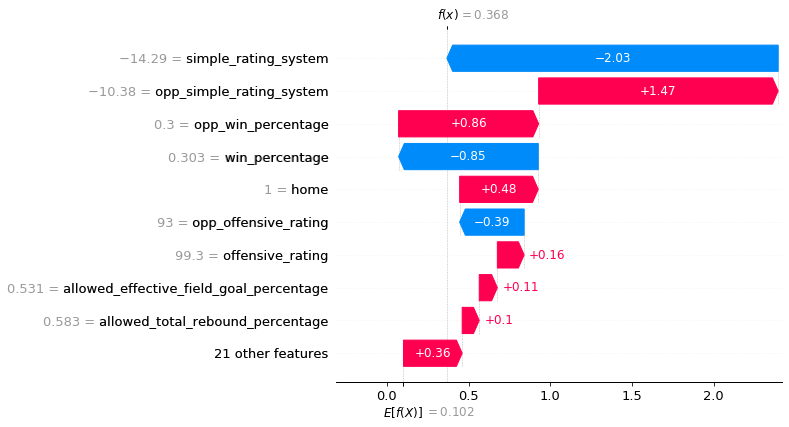

In [31]:
import shap
explainer = shap.Explainer(clf,X_train)
shap_values = explainer(X_test)
shap.plots.waterfall(shap_values[7])

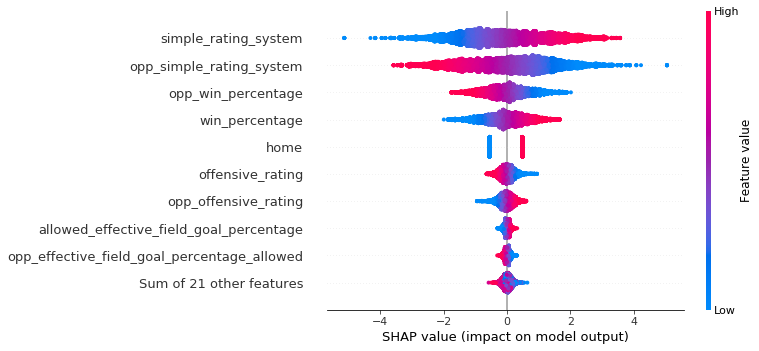

In [32]:
shap.plots.beeswarm(shap_values)

In [33]:
df_agg = pd.DataFrame()
for t in Teams(2022):
    try:
        temp_df = t.dataframe
        df_agg = pd.concat([df_agg,temp_df],axis=0)
    except:
        pass
        
in_agg = ['Southern Methodist','Brigham Young','University of California','Illinois-Chicago','Connecticut','Massachusetts','Nevada-Las Vegas','North Carolina',
         'North Carolina-Wilmington','North Carolina State','Pittsburgh','Louisiana State','Texas Christian','Southern California','Virginia Commonwealth']
to_change = ['SMU','BYU','California','UIC','UConn','UMass','UNLV','UNC','UNC Wilmington','NC State','Pitt','LSU','TCU','USC','VCU']
rename_dict = dict(zip(in_agg,to_change))
df_agg['name'] = df_agg.name.replace(rename_dict)
df_agg.to_csv('2022_agg.csv',index = False)
df_agg

,abbreviation,assist_percentage,assists,away_losses,away_wins,block_percentage,blocks,conference,conference_losses,conference_wins,defensive_rebounds,effective_field_goal_percentage,field_goal_attempts,field_goal_percentage,field_goals,free_throw_attempt_rate,free_throw_attempts,free_throw_percentage,free_throws,free_throws_per_field_goal_attempt,games_played,home_losses,home_wins,losses,minutes_played,name,net_rating,offensive_rating,offensive_rebound_percentage,offensive_rebounds,opp_assist_percentage,opp_assists,opp_block_percentage,opp_blocks,opp_defensive_rebounds,opp_effective_field_goal_percentage,opp_field_goal_attempts,opp_field_goal_percentage,opp_field_goals,opp_free_throw_attempt_rate,opp_free_throw_attempts,opp_free_throw_percentage,opp_free_throws,opp_free_throws_per_field_goal_attempt,opp_offensive_rating,opp_offensive_rebound_percentage,opp_offensive_rebounds,opp_personal_fouls,opp_points,opp_steal_percentage,opp_steals,opp_three_point_attempt_rate,opp_three_point_field_goal_attempts,opp_three_point_field_goal_percentage,opp_three_point_field_goals,opp_two_point_field_goal_attempts,opp_two_point_field_goal_percentage,opp_two_point_field_goals,opp_total_rebound_percentage,opp_total_rebounds,opp_true_shooting_percentage,opp_turnover_percentage,opp_turnovers,pace,personal_fouls,points,simple_rating_system,steal_percentage,steals,strength_of_schedule,three_point_attempt_rate,three_point_field_goal_attempts,three_point_field_goal_percentage,three_point_field_goals,two_point_field_goal_attempts,two_point_field_goal_percentage,two_point_field_goals,total_rebound_percentage,total_rebounds,true_shooting_percentage,turnover_percentage,turnovers,win_percentage,wins
ABILENE-CHRISTIAN,ABILENE-CHRISTIAN,56.0,252,3,3,6.0,28,wac,3,2,370,0.509,995,0.452,450,0.343,341,0.724,247,0.248,16,2,8,5,655,Abilene Christian,None,105.3,26.9,159,52.7,177,8.8,57,431,0.488,799,0.421,336,0.427,341,0.695,237,0.297,None,26.1,131,335,1017,7.9,94,0.414,331,0.326,108,468,0.487,228,51.5,562,0.529,27.5,364,73.1,341,1260,3.48,15.6,187,-0.93,0.347,345,0.328,113,650,0.518,337,48.5,529,0.545,14.9,203,0.688,11
AIR-FORCE,AIR-FORCE,59.3,169,4,1,10.3,46,mwc,1,1,302,0.536,626,0.455,285,0.230,144,0.660,95,0.152,13,0,5,5,520,Air Force,None,93.0,17.2,62,44.4,122,8.1,28,299,0.461,664,0.414,275,0.343,228,0.728,166,0.250,None,28.3,119,206,778,9.7,80,0.328,218,0.284,62,446,0.478,213,53.5,418,0.504,17.9,168,63.4,221,766,-6.27,10.0,82,-5.34,0.450,282,0.358,101,344,0.535,184,46.5,364,0.552,21.8,194,0.615,8
AKRON,AKRON,49.0,171,2,1,8.1,41,mac,2,2,369,0.525,771,0.453,349,0.415,320,0.656,210,0.272,14,1,7,5,560,Akron,None,109.0,32.4,154,38.3,124,6.1,27,322,0.477,773,0.419,324,0.274,212,0.670,142,0.184,None,23.8,115,286,879,8.5,80,0.343,265,0.336,89,508,0.463,235,45.5,437,0.503,16.8,176,66.8,233,1020,-0.15,8.9,83,-2.15,0.429,331,0.338,112,440,0.539,237,54.5,523,0.553,15.4,168,0.643,9
ALABAMA-AM,ALABAMA-AM,42.4,131,9,2,7.8,35,swac,1,3,360,0.413,817,0.378,309,0.275,225,0.684,154,0.188,14,1,2,10,560,Alabama A&M,None,85.6,26.2,142,63.7,218,7.0,43,401,0.491,823,0.416,342,0.275,226,0.695,157,0.191,None,30.6,159,220,966,10.3,100,0.456,375,0.333,125,448,0.484,217,52.7,560,0.519,17.3,195,69.2,226,829,-14.58,10.8,105,-4.80,0.245,200,0.285,57,617,0.408,252,47.3,502,0.449,17.0,189,0.286,4
ALABAMA-BIRMINGHAM,ALABAMA-BIRMINGHAM,44.1,245,2,2,11.9,77,cusa,1,4,480,0.529,1183,0.469,555,0.256,303,0.700,212,0.179,18,1,11,4,720,Alabama-Birmingham,None,112.0,32.7,225,48.0,190,8.5,68,464,0.452,1005,0.394,396,0.294,295,0.708,209,0.208,None,25.5,164,277,1118,7.1,93,0.358,360,0.325,117,645,0.433,279,47.1,628,0.488,22.3,329,72.6,297,1464,12.96,14.9,195,-1.73,0.324,383,0.371,142,800,0.516,413,52.9,705,0.552,13.2,201,0.778,14
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,.

In [68]:
team_1 = 'Purdue'
team_2 = 'Nebraska'
home_team = team_1
away_team = team_2
if team_1 in df_agg.name.unique().tolist():
    if team_2 in df_agg.name.unique().tolist():
        temp_df_2 = df_agg.loc[df_agg.name == team_1].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        temp_df_3 = df_agg.loc[df_agg.name == team_2].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        old_names = temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()
        new_names = [i.replace('opp','allowed') for i in temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()]
        name_dict = dict(zip(old_names,new_names))
        temp_df_2_dict = temp_df_2.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_2_dict.update(temp_df_3.iloc[0,:10].rename(dict(zip(temp_df_3.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_3.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,25:].rename(dict(zip(temp_df_3.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_3.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,10:25].rename(dict(zip(temp_df_3.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_3.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict = temp_df_3.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_3_dict.update(temp_df_2.iloc[0,:10].rename(dict(zip(temp_df_2.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_2.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,25:].rename(dict(zip(temp_df_2.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_2.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,10:25].rename(dict(zip(temp_df_2.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_2.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        for i in temp_df_3_dict.keys():
            temp_df_2_dict[i]+=(temp_df_3_dict[i])
        master_dict = {key:[] for key in temp_df_2_dict.keys()}

        for i in temp_df_2_dict.keys():
            master_dict[i] += temp_df_2_dict[i]
        df_pred = pd.DataFrame.from_dict(master_dict)
        df_pred = df_pred[df_pred.name == home_team]
        df_pred['home'] = 1
        df_pred = df_pred[wl_cols]
        
        for i in df_pred.loc[:,df_pred.columns[df_pred.columns.str.contains('percent')]].columns:
             if df_pred[i].max() > 1:
                df_pred[i] = [j/100 for j in df_pred[i]]
                 
    else:
        print("Away Team Not Formatted Correctly")
        df_pred = None
else:
    print("Home Team Not Formatted Correctly")
    df_pred = None
if df_pred is not None:
    display(df_pred)

loss_prob = clf.predict_proba(df_pred)[0][0]
win_prob = clf.predict_proba(df_pred)[0][1]

if win_prob >= loss_prob:
    print(home_team + ' has a ' + str(round(win_prob*100,2)) + '% chance of winning at home against ' +away_team)
else:
    print(away_team + ' has a ' + str(round(loss_prob*100,2)) + '% chance of winning on the road against ' + home_team)

,block_percentage,effective_field_goal_percentage,offensive_rating,offensive_rebound_percentage,allowed_effective_field_goal_percentage,allowed_free_throw_attempt_rate,allowed_steal_percentage,allowed_three_point_field_goal_percentage,allowed_total_rebound_percentage,simple_rating_system,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,turnover_percentage,win_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_offensive_rating,opp_offensive_rebound_percentage,opp_simple_rating_system,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_turnover_percentage,opp_win_percentage,opp_effective_field_goal_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,home
0,0.114,0.59,124.3,0.386,0.482,0.206,0.079,0.327,0.408,22.61,0.401,0.581,0.592,0.145,0.875,0.076,0.492,97.4,0.206,-0.48,0.295,0.523,0.441,0.155,0.333,0.515,0.097,0.36,0.559,1


Purdue has a 98.27% chance of winning at home against Nebraska


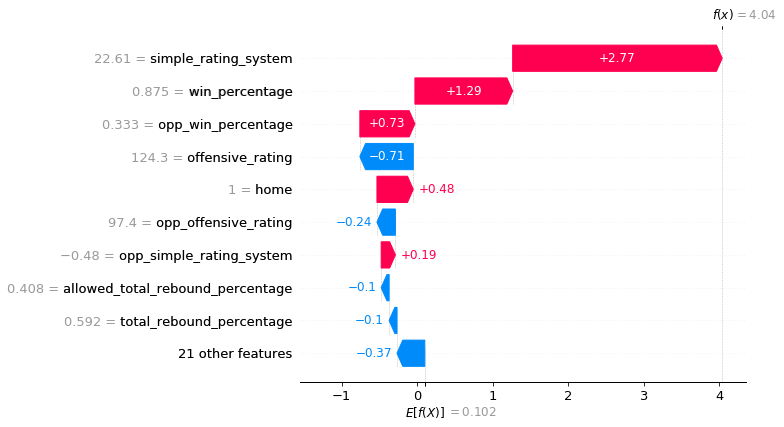

In [69]:
shap_values = explainer(df_pred)
shap.plots.waterfall(shap_values[0])

# Predicting Scores

## Points For

In [114]:
df_points = pd.read_csv('ml_df_l3.csv')
df_points = df_points.drop(columns = [df_points.columns[i] for i in [0,71,72,74,75,77,7,8,17,42,43,62,73,79]],axis = 1)
for i in df_points.loc[:,df_points.columns[df_points.columns.str.contains('percent')]].columns:
    if df_points[i].max() > 1:
        print("Rescaling {}".format(i))
        df_points[i] = [j/100 for j in df_points[i]]
X = df_points.drop('points_for',axis = 1)
y = df_points.points_for
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.sample(5)

Rescaling assist_percentage
Rescaling block_percentage
Rescaling offensive_rebound_percentage
Rescaling allowed_assist_percentage
Rescaling allowed_block_percentage
Rescaling allowed_offensive_rebound_percentage
Rescaling allowed_steal_percentage
Rescaling allowed_total_rebound_percentage
Rescaling allowed_turnover_percentage
Rescaling steal_percentage
Rescaling total_rebound_percentage
Rescaling turnover_percentage
Rescaling opp_assist_percentage
Rescaling opp_block_percentage
Rescaling opp_offensive_rebound_percentage
Rescaling opp_steal_percentage
Rescaling opp_total_rebound_percentage
Rescaling opp_turnover_percentage
Rescaling opp_assist_percentage_allowed
Rescaling opp_block_percentage_allowed
Rescaling opp_offensive_rebound_percentage_allowed
Rescaling opp_steal_percentage_allowed
Rescaling opp_total_rebound_percentage_allowed
Rescaling opp_turnover_percentage_allowed


,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,offensive_rating,offensive_rebound_percentage,allowed_assist_percentage,allowed_block_percentage,allowed_effective_field_goal_percentage,allowed_field_goal_percentage,allowed_free_throw_attempt_rate,allowed_free_throw_percentage,allowed_offensive_rebound_percentage,allowed_steal_percentage,allowed_three_point_attempt_rate,allowed_three_point_field_goal_percentage,allowed_two_point_field_goal_percentage,allowed_total_rebound_percentage,allowed_true_shooting_percentage,allowed_turnover_percentage,pace,simple_rating_system,steal_percentage,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage,opp_assist_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_field_goal_percentage,opp_free_throw_attempt_rate,opp_free_throw_percentage,opp_offensive_rating,opp_offensive_rebound_percentage,opp_pace,opp_simple_rating_system,opp_steal_percentage,opp_three_point_attempt_rate,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_true_shooting_percentage,opp_turnover_percentage,opp_win_percentage,opp_assist_percentage_allowed,opp_block_percentage_allowed,opp_effective_field_goal_percentage_allowed,opp_field_goal_percentage_allowed,opp_free_throw_attempt_rate_allowed,opp_free_throw_percentage_allowed,opp_offensive_rebound_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_attempt_rate_allowed,opp_three_point_field_goal_percentage_allowed,opp_two_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,opp_true_shooting_percentage_allowed,opp_turnover_percentage_allowed,home
3056,0.607,0.073,0.555,0.481,0.318,0.731,106.4,0.255,0.555,0.079,0.544,0.470,0.292,0.715,0.276,0.088,0.390,0.383,0.525,0.503,0.570,0.163,67.0,1.64,0.077,0.440,0.337,0.595,0.497,0.583,0.181,0.452,0.486,0.151,0.540,0.461,0.303,0.678,108.8,0.260,67.9,3.22,0.107,0.413,0.385,0.514,0.477,0.562,0.145,0.686,0.593,0.098,0.471,0.393,0.370,0.697,0.323,0.072,0.459,0.341,0.437,0.523,0.510,0.178,1
67053,0.409,0.111,0.488,0.447,0.457,0.682,106.6,0.373,0.511,0.096,0.486,0.418,0.464,0.687,0.256,0.078,0.399,0.340,0.470,0.444,0.529,0.168,68.8,1.84,0.098,0.263,0.311,0.496,0.556,0.529,0.156,0.606,0.561,0.073,0.516,0.448,0.296,0.680,100.0,0.257,72.5,2.20,0.077,0.364,0.374,0.491,0.502,0.541,0.179,0.281,0.580,0.100,0.532,0.470,0.396,0.756,0.241,0.106,0.352,0.354,0.532,0.498,0.574,0.154,0
8921,0.460,0.087,0.489,0.433,0.359,0.734,99.6,0.250,0.547,0.074,0.515,0.451,0.273,0.698,0.265,0.077,0.380,0.340,0.519,0.511,0.540,0.194,66.8,2.04,0.098,0.333,0.334,0.483,0.489,0.530,0.162,0.600,0.466,0.084,0.542,0.483,0.239,0.713,112.8,0.311,66.8,9.42,0.103,0.316,0.367,0.537,0.537,0.563,0.133,0.839,0.463,0.076,0.478,0.422,0.288,0.719,0.249,0.081,0.360,0.312,0.484,0.463,0.512,0.167,1
67250,0.620,0.095,0.523,0.460,0.361,0.763,109.8,0.318,0.487,0.088,0.458,0.392,0.259,0.697,0.214,0.096,0.423,0.314,0.449,0.434,0.488,0.158,68.9,13.66,0.088,0.379,0.333,0.538,0.566,0.564,0.156,0.765,0.449,0.106,0.527,0.471,0.354,0.769,112.8,0.351,70.8,14.43,0.088,0.343,0.327,0.547,0.543,0.568,0.151,0.677,0.484,0.083,0.494,0.423,0.264,0.688,0.285,0.081,0.414,0.345,0.478,0.457,0.520,0.144,1
40558,0.561,0.088,0.505,0.441,0.315,0.680,103.2,0.304,0.548,0.100,0.509,0.458,0.400,0.666,0.311,0.098,0.286,0.355,0.500,0.507,0.540,0.168,69.0,-6.50,0.092,0.394,0.326,0.515,0.493,0.532,0.163,0.500,0.555,0.076,0.560,0.484,0.273,0.698,107.1,0.241,60.5,-2.91,0.084,0.391,0.390,0.544,0.493,0.580,0.168,0.485,0.500,0.090,0.503,0.442,0.343,0.668,0.281,0.093,0.323,0.380,0.472,0.507,0.531,0.145,1


In [115]:
pf_reg = RandomForestRegressor(n_jobs = -1,n_estimators = 200,min_samples_split=650)
pf_reg.fit(X_train,y_train)
print('Training R2: {} | Training MSE: {}'.format(pf_reg.score(X_train,y_train),mean_squared_error(y_train,pf_reg.predict(X_train),squared = False)))
print('Testing:',pf_reg.score(X_test,y_test),mean_squared_error(y_test,pf_reg.predict(X_test),squared = False))

Training R2: 0.34962678178665185 | Training MSE: 10.010345612244574
Testing: 0.32573876861324924 10.159969697454995


In [116]:
imp_dict = {key:[] for key in ('feature','importance')}
for feat,imp in zip(X_train.columns,pf_reg.feature_importances_):
    imp_dict['feature'].append(feat)
    imp_dict['importance'].append(imp)
    
imp_df = pd.DataFrame.from_dict(imp_dict)
imp_feats = imp_df.sort_values('importance',ascending = False).head(40)['feature'].tolist()
imp_df.sort_values('importance',ascending = False).head(25)

,feature,importance
6,offensive_rating,0.370576
40,opp_pace,0.225255
52,opp_effective_field_goal_percentage_allowed,0.127056
64,home,0.073698
22,pace,0.064686
62,opp_true_shooting_percentage_allowed,0.043513
41,opp_simple_rating_system,0.031902
53,opp_field_goal_percentage_allowed,0.026214
23,simple_rating_system,0.012196
49,opp_win_percentage,0.009760


In [118]:
df2 = df_points[imp_feats]
corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
for tup in high_corr_var:
    print('Removing {} as it is highly correllated with {}'.format(tup[1],tup[0]))

to_drop = []
for x,y in high_corr_var:
    if y not in to_drop:
        to_drop.append(y)

df2 = df2.drop([i for i in to_drop],axis = 1)

corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
assert high_corr_var == []
X = df2
y = df_points.points_for
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train

Removing opp_true_shooting_percentage_allowed as it is highly correllated with opp_effective_field_goal_percentage_allowed
Removing opp_field_goal_percentage_allowed as it is highly correllated with opp_effective_field_goal_percentage_allowed
Removing opp_field_goal_percentage_allowed as it is highly correllated with opp_true_shooting_percentage_allowed
Removing opp_two_point_field_goal_percentage_allowed as it is highly correllated with opp_field_goal_percentage_allowed
Removing effective_field_goal_percentage as it is highly correllated with true_shooting_percentage


,offensive_rating,opp_pace,opp_effective_field_goal_percentage_allowed,home,pace,opp_simple_rating_system,simple_rating_system,opp_win_percentage,opp_turnover_percentage_allowed,opp_offensive_rebound_percentage_allowed,opp_three_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,opp_steal_percentage,opp_total_rebound_percentage,turnover_percentage,three_point_attempt_rate,opp_three_point_attempt_rate,free_throw_attempt_rate,win_percentage,true_shooting_percentage,allowed_three_point_attempt_rate,allowed_offensive_rebound_percentage,opp_assist_percentage_allowed,opp_three_point_attempt_rate_allowed,opp_turnover_percentage,opp_offensive_rating,opp_assist_percentage,opp_free_throw_attempt_rate_allowed,allowed_block_percentage,opp_offensive_rebound_percentage,opp_steal_percentage_allowed,three_point_field_goal_percentage,opp_block_percentage,opp_two_point_field_goal_percentage,opp_free_throw_percentage_allowed,offensive_rebound_percentage
28396,103.9,74.3,0.504,1,69.1,-5.83,-6.40,0.514,0.165,0.328,0.360,0.525,0.088,0.475,0.173,0.373,0.372,0.362,0.647,0.544,0.330,0.323,0.513,0.321,0.159,106.5,0.578,0.382,0.101,0.272,0.095,0.351,0.121,0.511,0.676,0.305
19540,111.7,67.7,0.503,1,66.1,8.47,18.22,0.516,0.155,0.269,0.352,0.481,0.080,0.519,0.151,0.373,0.383,0.289,0.774,0.567,0.406,0.311,0.507,0.353,0.173,103.2,0.565,0.230,0.096,0.289,0.097,0.396,0.072,0.520,0.731,0.327
53010,112.8,69.8,0.462,1,69.5,18.79,18.05,0.735,0.141,0.247,0.316,0.435,0.068,0.565,0.139,0.340,0.294,0.406,0.816,0.562,0.343,0.303,0.483,0.313,0.157,112.8,0.513,0.293,0.077,0.349,0.077,0.343,0.113,0.522,0.713,0.342
50225,109.9,66.8,0.470,1,68.8,-5.25,-1.29,0.406,0.126,0.297,0.325,0.482,0.075,0.518,0.162,0.326,0.280,0.390,0.529,0.561,0.355,0.286,0.530,0.384,0.166,104.9,0.469,0.350,0.074,0.306,0.088,0.362,0.126,0.510,0.684,0.346
29844,103.4,65.5,0.456,1,73.5,15.19,9.84,0.667,0.172,0.305,0.357,0.468,0.116,0.532,0.138,0.299,0.366,0.419,0.559,0.511,0.323,0.296,0.507,0.352,0.137,108.9,0.597,0.270,0.109,0.366,0.076,0.324,0.155,0.477,0.680,0.324
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
6606,122.2,69.1,0.561,1,71.7,-11.84,27.79,0.267,0.143,0.229,0.418,0.485,0.068,0.515,0.131,0.353,0.361,0.353,0.892,0.620,0.349,0.260,0.521,0.435,0.174,100.3,0.469,0.282,0.058,0.267,0.085,0.363,0.079,0.480,0.724,0.304
51627,101.5,64.9,0.482,0,71.7,15.39,6.94,0.735,0.203,0.256,0.314,0.491,0.116,0.509,0.177,0.391,0.384,0.389,0.417,0.514,0.362,0.285,0.545,0.429,0.152,101.3,0.576,0.307,0.100,0.284,0.096,0.316,0.077,0.488,0.674,0.366
20468,100.9,72.5,0.554,1,69.4,4.02,0.13,0.455,0.159,0.322,0.364,0.549,0.081,0.451,0.165,0.330,0.438,0.280,0.419,0.553,0.368,0.289,0.635,0.409,0.127,108.0,0.484,0.300,0.077,0.244,0.071,0.364,0.088,0.487,0.712,0.199
51151,108.2,66.3,0.501,1,67.2,5.92,1.74,0.636,0.150,0.297,0.350,0.480,0.080,0.520,0.156,0.318,0.340,0.404,0.529,0.552,0.380,0.274,0.465,0.354,0.147,111.2,0.556,0.407,0.101,0.333,0.083,0.360,0.072,0.530,0.701,0.325


In [119]:
import statsmodels.api as sm
X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

                            OLS Regression Results                            
Dep. Variable:             points_for   R-squared:                       0.398
Model:                            OLS   Adj. R-squared:                  0.397
Method:                 Least Squares   F-statistic:                     1011.
Date:                Sat, 15 Jan 2022   Prob (F-statistic):               0.00
Time:                        20:25:09   Log-Likelihood:            -2.0312e+05
No. Observations:               55120   AIC:                         4.063e+05
Df Residuals:                   55083   BIC:                         4.066e+05
Df Model:                          36                                         
Covariance Type:            nonrobust                                         
                                                    coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------------------------

In [121]:
pvals = est2.pvalues.to_frame('p_val').reset_index().rename(columns = {'index':'coef'})
pvals['p_val'] = round(pvals.p_val,3)
sig_vars = pvals[pvals.p_val <= 0.05]['coef'].tolist()
df3 = df2[sig_vars]
X = df3
y = df_points.points_for
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.sample(5)

,offensive_rating,opp_pace,opp_effective_field_goal_percentage_allowed,home,pace,opp_simple_rating_system,simple_rating_system,opp_turnover_percentage_allowed,opp_offensive_rebound_percentage_allowed,opp_steal_percentage,free_throw_attempt_rate,win_percentage,allowed_three_point_attempt_rate,allowed_offensive_rebound_percentage,opp_three_point_attempt_rate_allowed,opp_turnover_percentage,opp_offensive_rating,opp_free_throw_attempt_rate_allowed,allowed_block_percentage,opp_offensive_rebound_percentage,opp_steal_percentage_allowed,opp_block_percentage,opp_two_point_field_goal_percentage,opp_free_throw_percentage_allowed
71741,97.4,66.9,0.483,0,69.5,13.96,-19.21,0.157,0.292,0.089,0.324,0.265,0.344,0.363,0.352,0.146,103.9,0.262,0.081,0.295,0.077,0.128,0.512,0.712
7110,96.7,71.4,0.554,1,70.3,-8.80,-8.18,0.161,0.313,0.089,0.390,0.424,0.367,0.324,0.352,0.162,105.8,0.352,0.089,0.269,0.099,0.072,0.541,0.701
52560,91.8,69.5,0.541,1,70.5,-22.67,-11.27,0.160,0.317,0.091,0.421,0.667,0.283,0.265,0.333,0.197,88.2,0.383,0.082,0.267,0.118,0.099,0.419,0.674
47829,97.4,72.7,0.525,0,71.6,-6.00,-8.16,0.177,0.280,0.094,0.380,0.344,0.425,0.310,0.357,0.151,100.1,0.337,0.098,0.282,0.085,0.071,0.466,0.727
63259,110.0,67.3,0.485,0,65.2,12.07,-1.02,0.156,0.286,0.098,0.411,0.706,0.408,0.262,0.385,0.149,106.1,0.323,0.070,0.338,0.093,0.110,0.474,0.696


In [122]:
pf_reg = LinearRegression(n_jobs = -1)
pf_reg.fit(X_train,y_train)
print('Training:',pf_reg.score(X_train,y_train),mean_squared_error(y_train,pf_reg.predict(X_train),squared = False))
print('Testing:',pf_reg.score(X_test,y_test),mean_squared_error(y_test,pf_reg.predict(X_test),squared = False))

Training: 0.3989430377302152 9.644920734044327
Testing: 0.3924285182535616 9.578990725374645


In [123]:
team_1 = 'Kansas'
team_2 = 'West Virginia'
home_team = team_1
away_team = team_2
if team_1 in df_agg.name.unique().tolist():
    if team_2 in df_agg.name.unique().tolist():
        temp_df_2 = df_agg.loc[df_agg.name == team_1].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        temp_df_3 = df_agg.loc[df_agg.name == team_2].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        old_names = temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()
        new_names = [i.replace('opp','allowed') for i in temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()]
        name_dict = dict(zip(old_names,new_names))
        temp_df_2_dict = temp_df_2.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_2_dict.update(temp_df_3.iloc[0,:10].rename(dict(zip(temp_df_3.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_3.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,25:].rename(dict(zip(temp_df_3.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_3.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,10:25].rename(dict(zip(temp_df_3.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_3.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict = temp_df_3.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_3_dict.update(temp_df_2.iloc[0,:10].rename(dict(zip(temp_df_2.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_2.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,25:].rename(dict(zip(temp_df_2.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_2.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,10:25].rename(dict(zip(temp_df_2.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_2.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        for i in temp_df_3_dict.keys():
            temp_df_2_dict[i]+=(temp_df_3_dict[i])
        master_dict = {key:[] for key in temp_df_2_dict.keys()}

        for i in temp_df_2_dict.keys():
            master_dict[i] += temp_df_2_dict[i]
        df_pred = pd.DataFrame.from_dict(master_dict)
        df_pred = df_pred[df_pred.name == home_team]
        df_pred['home'] = 1
        for i in df_pred.loc[:,df_pred.columns[df_pred.columns.str.contains('percent')]].columns:
             if df_pred[i].max() > 1:
                df_pred[i] = [j/100 for j in df_pred[i]]
        #Create the win/loss model dataframe
        
        df_wl = df_pred[wl_cols]
        
                 
    else:
        print("Away Team Not Formatted Correctly")
        df_wl = None
else:
    print("Home Team Not Formatted Correctly")
    df_wl = None

loss_prob = clf.predict_proba(df_wl)[0][0]
win_prob = clf.predict_proba(df_wl)[0][1]

if win_prob >= loss_prob:
    print(home_team + ' has a ' + str(round(win_prob*100,2)) + '% chance of winning at home against ' +away_team)
else:
    print(away_team + ' has a ' + str(round(loss_prob*100,2)) + '% chance of winning on the road against ' + home_team)

# Create the points for model dataframe
df_pf = df_pred[sig_vars]
predicted_points_for = int(round(pf_reg.predict(df_pred[sig_vars])[0]))

#Print out prediction
print("{} is predicted to score {} points".format(home_team,predicted_points_for))

Kansas has a 74.67% chance of winning at home against West Virginia
Kansas is predicted to score 75 points


## Points Against

In [124]:
df_points_a = pd.read_csv('ml_df_l3.csv')
df_points_a = df_points_a.drop(columns = [df_points_a.columns[i] for i in [0,71,72,74,75,77,7,8,17,42,43,62,73,78]],axis = 1)
for i in df_points_a.loc[:,df_points_a.columns[df_points_a.columns.str.contains('percent')]].columns:
    if df_points_a[i].max() > 1:
        print("Rescaling {}".format(i))
        df_points_a[i] = [j/100 for j in df_points_a[i]]
X = df_points_a.drop('points_against',axis = 1)
y = df_points_a.points_against
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.sample(5)

Rescaling assist_percentage
Rescaling block_percentage
Rescaling offensive_rebound_percentage
Rescaling allowed_assist_percentage
Rescaling allowed_block_percentage
Rescaling allowed_offensive_rebound_percentage
Rescaling allowed_steal_percentage
Rescaling allowed_total_rebound_percentage
Rescaling allowed_turnover_percentage
Rescaling steal_percentage
Rescaling total_rebound_percentage
Rescaling turnover_percentage
Rescaling opp_assist_percentage
Rescaling opp_block_percentage
Rescaling opp_offensive_rebound_percentage
Rescaling opp_steal_percentage
Rescaling opp_total_rebound_percentage
Rescaling opp_turnover_percentage
Rescaling opp_assist_percentage_allowed
Rescaling opp_block_percentage_allowed
Rescaling opp_offensive_rebound_percentage_allowed
Rescaling opp_steal_percentage_allowed
Rescaling opp_total_rebound_percentage_allowed
Rescaling opp_turnover_percentage_allowed


,assist_percentage,block_percentage,effective_field_goal_percentage,field_goal_percentage,free_throw_attempt_rate,free_throw_percentage,offensive_rating,offensive_rebound_percentage,allowed_assist_percentage,allowed_block_percentage,allowed_effective_field_goal_percentage,allowed_field_goal_percentage,allowed_free_throw_attempt_rate,allowed_free_throw_percentage,allowed_offensive_rebound_percentage,allowed_steal_percentage,allowed_three_point_attempt_rate,allowed_three_point_field_goal_percentage,allowed_two_point_field_goal_percentage,allowed_total_rebound_percentage,allowed_true_shooting_percentage,allowed_turnover_percentage,pace,simple_rating_system,steal_percentage,three_point_attempt_rate,three_point_field_goal_percentage,two_point_field_goal_percentage,total_rebound_percentage,true_shooting_percentage,turnover_percentage,win_percentage,opp_assist_percentage,opp_block_percentage,opp_effective_field_goal_percentage,opp_field_goal_percentage,opp_free_throw_attempt_rate,opp_free_throw_percentage,opp_offensive_rating,opp_offensive_rebound_percentage,opp_pace,opp_simple_rating_system,opp_steal_percentage,opp_three_point_attempt_rate,opp_three_point_field_goal_percentage,opp_two_point_field_goal_percentage,opp_total_rebound_percentage,opp_true_shooting_percentage,opp_turnover_percentage,opp_win_percentage,opp_assist_percentage_allowed,opp_block_percentage_allowed,opp_effective_field_goal_percentage_allowed,opp_field_goal_percentage_allowed,opp_free_throw_attempt_rate_allowed,opp_free_throw_percentage_allowed,opp_offensive_rebound_percentage_allowed,opp_steal_percentage_allowed,opp_three_point_attempt_rate_allowed,opp_three_point_field_goal_percentage_allowed,opp_two_point_field_goal_percentage_allowed,opp_total_rebound_percentage_allowed,opp_true_shooting_percentage_allowed,opp_turnover_percentage_allowed,home
14733,0.479,0.085,0.472,0.399,0.334,0.733,94.4,0.180,0.524,0.076,0.500,0.429,0.252,0.751,0.280,0.089,0.391,0.362,0.472,0.556,0.531,0.186,64.7,1.29,0.100,0.450,0.326,0.459,0.444,0.513,0.159,0.467,0.558,0.144,0.513,0.439,0.301,0.664,104.6,0.306,65.8,10.30,0.108,0.404,0.369,0.486,0.517,0.536,0.159,0.800,0.528,0.077,0.443,0.379,0.324,0.692,0.285,0.088,0.388,0.328,0.411,0.483,0.481,0.167,0
20637,0.587,0.094,0.482,0.405,0.319,0.695,93.7,0.233,0.581,0.153,0.501,0.439,0.313,0.708,0.339,0.101,0.372,0.334,0.501,0.545,0.532,0.131,65.7,-1.87,0.065,0.475,0.325,0.478,0.455,0.515,0.187,0.250,0.526,0.140,0.532,0.468,0.370,0.691,109.5,0.320,72.2,15.78,0.094,0.368,0.350,0.536,0.518,0.562,0.154,0.657,0.487,0.077,0.484,0.417,0.324,0.714,0.293,0.080,0.377,0.355,0.454,0.482,0.519,0.167,0
35062,0.518,0.101,0.509,0.458,0.349,0.704,107.4,0.379,0.506,0.097,0.499,0.433,0.363,0.720,0.290,0.099,0.386,0.345,0.488,0.452,0.538,0.138,65.4,-10.26,0.072,0.282,0.359,0.497,0.548,0.542,0.170,0.344,0.589,0.110,0.521,0.441,0.291,0.677,104.4,0.319,64.0,-14.04,0.093,0.455,0.350,0.518,0.483,0.544,0.177,0.375,0.483,0.087,0.509,0.458,0.365,0.684,0.355,0.111,0.297,0.343,0.507,0.517,0.540,0.139,1
64161,0.478,0.107,0.490,0.437,0.288,0.708,101.0,0.331,0.510,0.068,0.446,0.389,0.400,0.696,0.245,0.079,0.348,0.328,0.422,0.450,0.492,0.133,68.5,-0.22,0.074,0.319,0.335,0.484,0.550,0.521,0.172,0.514,0.544,0.093,0.525,0.463,0.338,0.734,106.4,0.258,66.6,12.85,0.119,0.368,0.341,0.534,0.474,0.560,0.153,0.676,0.545,0.071,0.491,0.425,0.368,0.732,0.317,0.084,0.399,0.330,0.489,0.526,0.533,0.186,0
7261,0.505,0.052,0.460,0.403,0.301,0.654,93.5,0.269,0.520,0.094,0.524,0.461,0.330,0.721,0.280,0.096,0.347,0.361,0.515,0.515,0.556,0.146,69.2,-16.33,0.075,0.359,0.319,0.450,0.485,0.489,0.165,0.219,0.543,0.053,0.516,0.443,0.445,0.759,105.1,0.271,72.1,-8.55,0.105,0.401,0.367,0.493,0.478,0.566,0.176,0.433,0.534,0.128,0.567,0.499,0.373,0.714,0.296,0.097,0.369,0.372,0.573,0.522,0.595,0.194,0


In [128]:
pa_reg = RandomForestRegressor(n_jobs = -1,n_estimators = 300,min_samples_split=650)
pa_reg.fit(X_train,y_train)
print('Training R2: {} | Training MSE: {}'.format(pa_reg.score(X_train,y_train),mean_squared_error(y_train,pa_reg.predict(X_train),squared = False)))
print('Testing R2: {} | Testing MSE: {}'.format(pa_reg.score(X_test,y_test),mean_squared_error(y_test,pa_reg.predict(X_test),squared = False)))

Training R2: 0.34825124358277615 | Training MSE: 9.99362451381677
Testing R2: 0.3325678205010639 | Testing MSE: 10.19115412071158


In [129]:
imp_dict = {key:[] for key in ('feature','importance')}
for feat,imp in zip(X_train.columns,pa_reg.feature_importances_):
    imp_dict['feature'].append(feat)
    imp_dict['importance'].append(imp)
    
imp_df = pd.DataFrame.from_dict(imp_dict)
imp_feats = imp_df.sort_values('importance',ascending = False).head(40)['feature'].tolist()

df2 = df_points_a[imp_feats]
corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
for tup in high_corr_var:
    print('Removing {} as it is highly correllated with {}'.format(tup[1],tup[0]))

to_drop = []
for x,y in high_corr_var:
    if y not in to_drop:
        to_drop.append(y)

df2 = df2.drop([i for i in to_drop],axis = 1)

corr=df2.corr()
high_corr_var=np.where(corr>0.9)
high_corr_var=[(corr.columns[x],corr.columns[y]) for x,y in zip(*high_corr_var) if x!=y and x<y]
assert high_corr_var == []
X = df2
y = df_points_a.points_against
X_train,X_test,y_train,y_test = train_test_split(X,y)


X2 = sm.add_constant(X_train)
est = sm.OLS(y_train, X2)
est2 = est.fit()
print(est2.summary())

Removing allowed_true_shooting_percentage as it is highly correllated with allowed_effective_field_goal_percentage
Removing allowed_field_goal_percentage as it is highly correllated with allowed_effective_field_goal_percentage
Removing allowed_field_goal_percentage as it is highly correllated with allowed_true_shooting_percentage
Removing allowed_two_point_field_goal_percentage as it is highly correllated with allowed_field_goal_percentage
Removing opp_effective_field_goal_percentage as it is highly correllated with opp_true_shooting_percentage
Removing opp_field_goal_percentage as it is highly correllated with opp_true_shooting_percentage
Removing opp_field_goal_percentage as it is highly correllated with opp_effective_field_goal_percentage
                            OLS Regression Results                            
Dep. Variable:         points_against   R-squared:                       0.399
Model:                            OLS   Adj. R-squared:                  0.398
Method:    

In [131]:
pvals = est2.pvalues.to_frame('p_val').reset_index().rename(columns = {'index':'coef'})
pvals['p_val'] = round(pvals.p_val,3)
sig_vars_pa = pvals[pvals.p_val <= 0.05]['coef'].tolist()
pa_vars = sig_vars_pa
df3 = df_points_a[sig_vars_pa]
X = df3
y = df_points.points_for
X_train,X_test,y_train,y_test = train_test_split(X,y)
X_train.sample(5)

,opp_offensive_rating,pace,allowed_effective_field_goal_percentage,opp_pace,home,simple_rating_system,opp_simple_rating_system,win_percentage,allowed_turnover_percentage,allowed_offensive_rebound_percentage,steal_percentage,allowed_three_point_field_goal_percentage,three_point_attempt_rate,opp_free_throw_attempt_rate,opp_offensive_rebound_percentage_allowed,opp_win_percentage,opp_block_percentage,free_throw_percentage,opp_three_point_attempt_rate_allowed,offensive_rebound_percentage,free_throw_attempt_rate,opp_free_throw_percentage,field_goal_percentage,two_point_field_goal_percentage,block_percentage,opp_effective_field_goal_percentage_allowed,opp_free_throw_attempt_rate_allowed
32752,101.4,62.1,0.457,64.0,0,2.04,-1.79,0.657,0.155,0.323,0.080,0.319,0.371,0.476,0.303,0.467,0.084,0.658,0.432,0.339,0.382,0.680,0.427,0.466,0.102,0.513,0.401
55013,96.8,63.5,0.462,74.2,0,-13.97,-17.58,0.200,0.146,0.286,0.063,0.321,0.411,0.337,0.352,0.207,0.053,0.693,0.320,0.272,0.331,0.678,0.376,0.408,0.095,0.526,0.387
64988,105.2,66.5,0.451,63.7,1,24.33,3.63,0.895,0.185,0.224,0.108,0.335,0.259,0.292,0.305,0.618,0.126,0.719,0.289,0.345,0.471,0.684,0.488,0.533,0.098,0.442,0.346
67933,108.9,74.0,0.535,69.9,0,-16.11,-0.98,0.258,0.204,0.338,0.107,0.328,0.357,0.368,0.275,0.636,0.082,0.675,0.340,0.288,0.317,0.716,0.416,0.483,0.052,0.529,0.323
27029,109.4,70.9,0.504,67.6,0,5.99,1.76,0.640,0.184,0.258,0.115,0.324,0.472,0.254,0.260,0.625,0.061,0.724,0.422,0.272,0.266,0.705,0.487,0.617,0.095,0.507,0.248


In [132]:
pa_reg = LinearRegression(n_jobs = -1)
pa_reg.fit(X_train,y_train)
print('Training:',pa_reg.score(X_train,y_train),mean_squared_error(y_train,pa_reg.predict(X_train),squared = False))
print('Testing:',pa_reg.score(X_test,y_test),mean_squared_error(y_test,pa_reg.predict(X_test),squared = False))

Training: 0.3945338654390055 9.654973619061929
Testing: 0.39814495731810595 9.609896684057098


In [138]:
team_1 = 'Illinois'
team_2 = 'Purdue'
home_team = team_1
away_team = team_2
if team_1 in df_agg.name.unique().tolist():
    if team_2 in df_agg.name.unique().tolist():
        temp_df_2 = df_agg.loc[df_agg.name == team_1].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        temp_df_3 = df_agg.loc[df_agg.name == team_2].loc[:,df_agg.columns[df_agg.columns.str.contains('percen') | df_agg.columns.str.contains('rat') | (df_agg.columns == 'pace') | (df_agg.columns == 'name')]]
        old_names = temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()
        new_names = [i.replace('opp','allowed') for i in temp_df_2.columns[temp_df_2.columns.str.contains('opp_')].to_list()]
        name_dict = dict(zip(old_names,new_names))
        temp_df_2_dict = temp_df_2.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_2_dict.update(temp_df_3.iloc[0,:10].rename(dict(zip(temp_df_3.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_3.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,25:].rename(dict(zip(temp_df_3.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_3.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_2_dict.update(temp_df_3.iloc[0,10:25].rename(dict(zip(temp_df_3.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_3.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict = temp_df_3.rename(columns = name_dict).to_dict(orient = 'list')
        temp_df_3_dict.update(temp_df_2.iloc[0,:10].rename(dict(zip(temp_df_2.iloc[0,:10].index,['opp_'+str(i) for i in temp_df_2.iloc[0,:10].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,25:].rename(dict(zip(temp_df_2.iloc[0,25:].index,['opp_'+str(i) for i in temp_df_2.iloc[0,25:].index]))).to_frame().transpose().to_dict(orient = 'list'))
        temp_df_3_dict.update(temp_df_2.iloc[0,10:25].rename(dict(zip(temp_df_2.iloc[0,10:25].index,[i + "_allowed" for i in temp_df_2.iloc[0,10:25].index]))).to_frame().transpose().to_dict(orient = 'list'))
        for i in temp_df_3_dict.keys():
            temp_df_2_dict[i]+=(temp_df_3_dict[i])
        master_dict = {key:[] for key in temp_df_2_dict.keys()}

        for i in temp_df_2_dict.keys():
            master_dict[i] += temp_df_2_dict[i]
        df_pred = pd.DataFrame.from_dict(master_dict)
        df_pred = df_pred[df_pred.name == home_team]
        df_pred['home'] = 1
        for i in df_pred.loc[:,df_pred.columns[df_pred.columns.str.contains('percent')]].columns:
             if df_pred[i].max() > 1:
                df_pred[i] = [j/100 for j in df_pred[i]]
        #Create the win/loss model dataframe
        
        df_wl = df_pred[wl_cols]
        
                 
    else:
        print("Away Team Not Formatted Correctly")
        df_wl = None
else:
    print("Home Team Not Formatted Correctly")
    df_wl = None

loss_prob = clf.predict_proba(df_wl)[0][0]
win_prob = clf.predict_proba(df_wl)[0][1]

if win_prob >= loss_prob:
    print(home_team + ' has a ' + str(round(win_prob*100,2)) + '% chance of winning at home against ' +away_team)
else:
    print(away_team + ' has a ' + str(round(loss_prob*100,2)) + '% chance of winning on the road against ' + home_team)

# Create the points for model dataframe
df_pf = df_pred[sig_vars]
predicted_points_for = int(round(pf_reg.predict(df_pf)[0]))

#Print out prediction
print("{} is predicted to score {} points".format(home_team,predicted_points_for))

#Create the points against model dataframe
df_pa = df_pred[sig_vars_pa]
predicted_points_against = int(round(pa_reg.predict(df_pa)[0]))

#Print out prediction
print("{} is predicted to score {} points".format(away_team,predicted_points_against))

Illinois has a 54.86% chance of winning at home against Purdue
Illinois is predicted to score 77 points
Purdue is predicted to score 78 points


In [ ]:
for i in df_points.columns.tolist():
    stat,p = stats.normaltest(df_points[i].tolist())
    if p <= 0.05:
        print("{} is normally distributed".format(i))